In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

root = "/Users/zyxu/Documents/py/FM_weights"
os.chdir(root)

In [30]:
loaded_tensor = torch.load(f'{root}/output/36_Cifar10_intermediate_outputs.pth')
print(loaded_tensor.shape)

torch.Size([13, 64, 197, 192])


In [31]:
from utils import intermdiates_to_pos_ctx
res = intermdiates_to_pos_ctx(loaded_tensor, normalize = False)
res.keys()

mu.shape torch.Size([13, 192])
expanded_mu_pos:  torch.Size([13, 197, 192])
expanded_mu_ctx:  torch.Size([13, 64, 192])
expanded_pos: torch.Size([13, 64, 197, 192]), expanded_ctx: torch.Size([13, 64, 197, 192]), expanded_mu_whole: torch.Size([13, 64, 197, 192])
resid: torch.Size([13, 64, 197, 192])
cvec: torch.Size([13, 64, 197, 192])


dict_keys(['mu', 'pos', 'ctx', 'resid', 'cvec'])

### PCA

Layer progress: 100%|██████████| 12/12 [00:00<00:00, 17.90it/s]


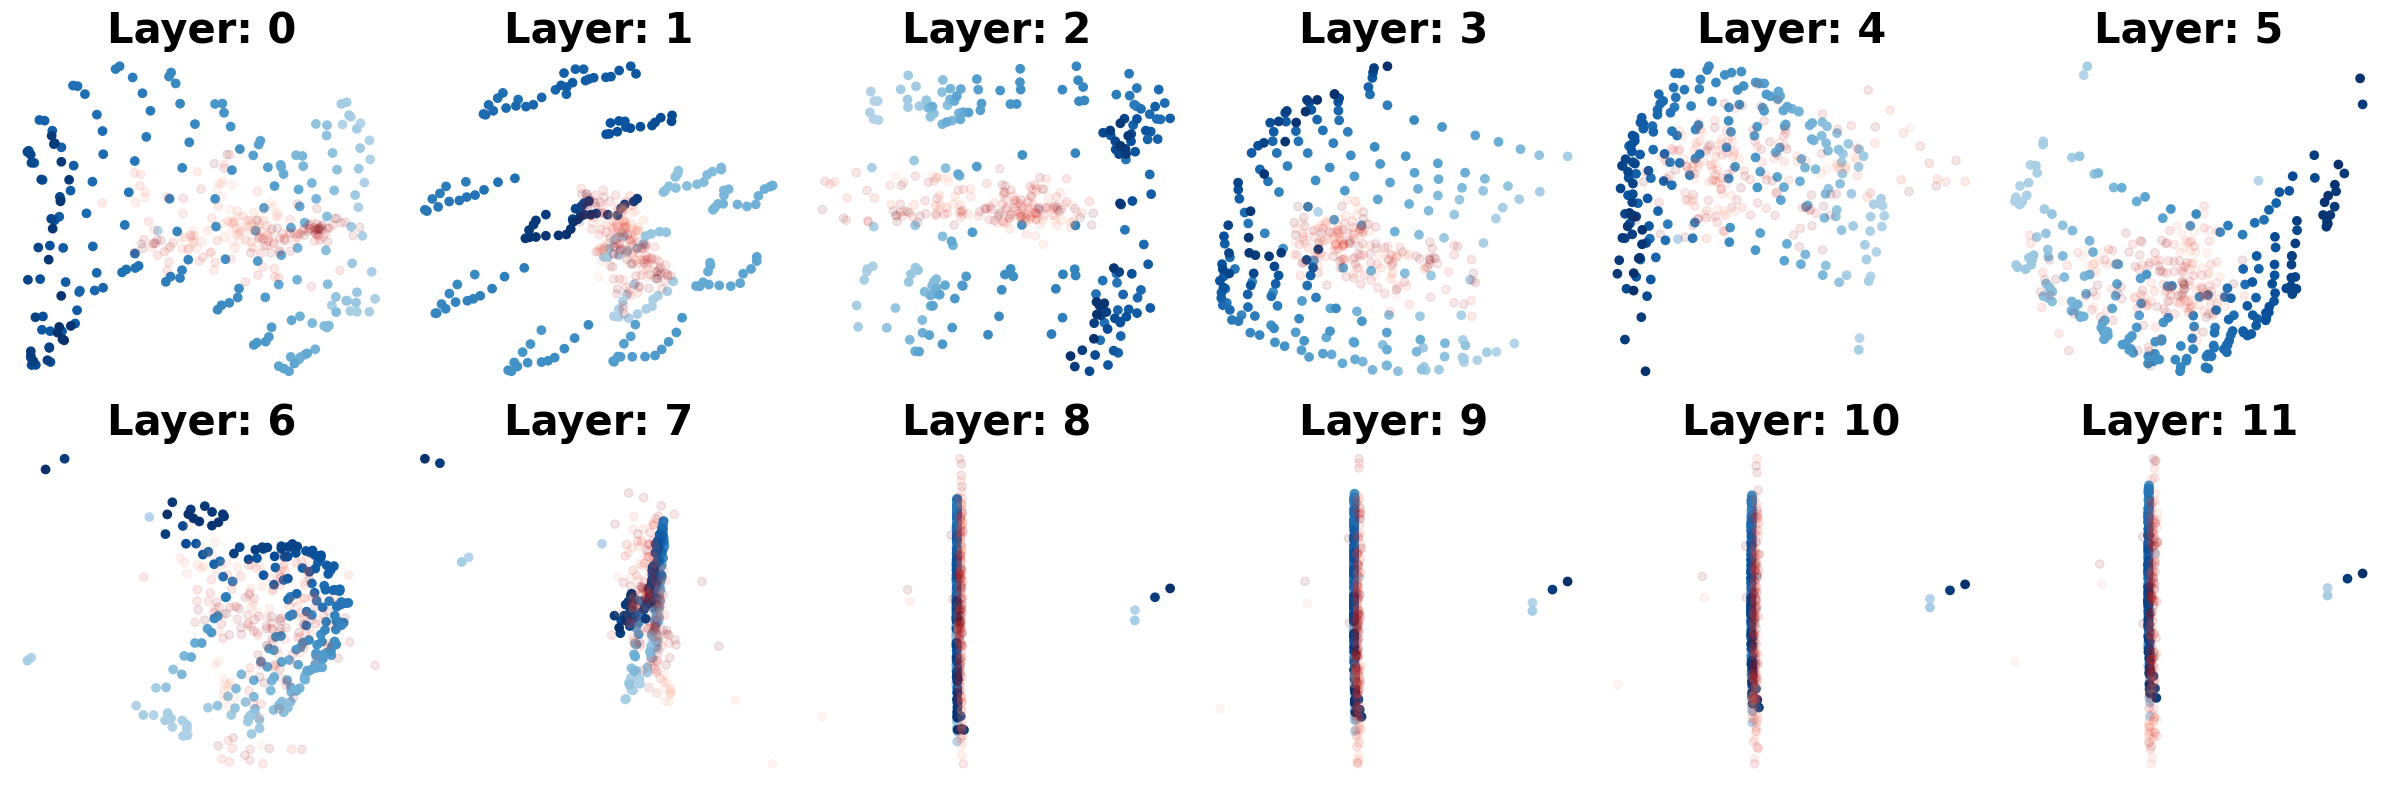

In [32]:
from utils import visz_pca_pos_cvec

visz_pca_pos_cvec.plot(res['pos'].detach(),res['cvec'].detach().view(13,-1,192), plot_context=True)

Layer progress: 100%|██████████| 12/12 [00:00<00:00, 36.70it/s]


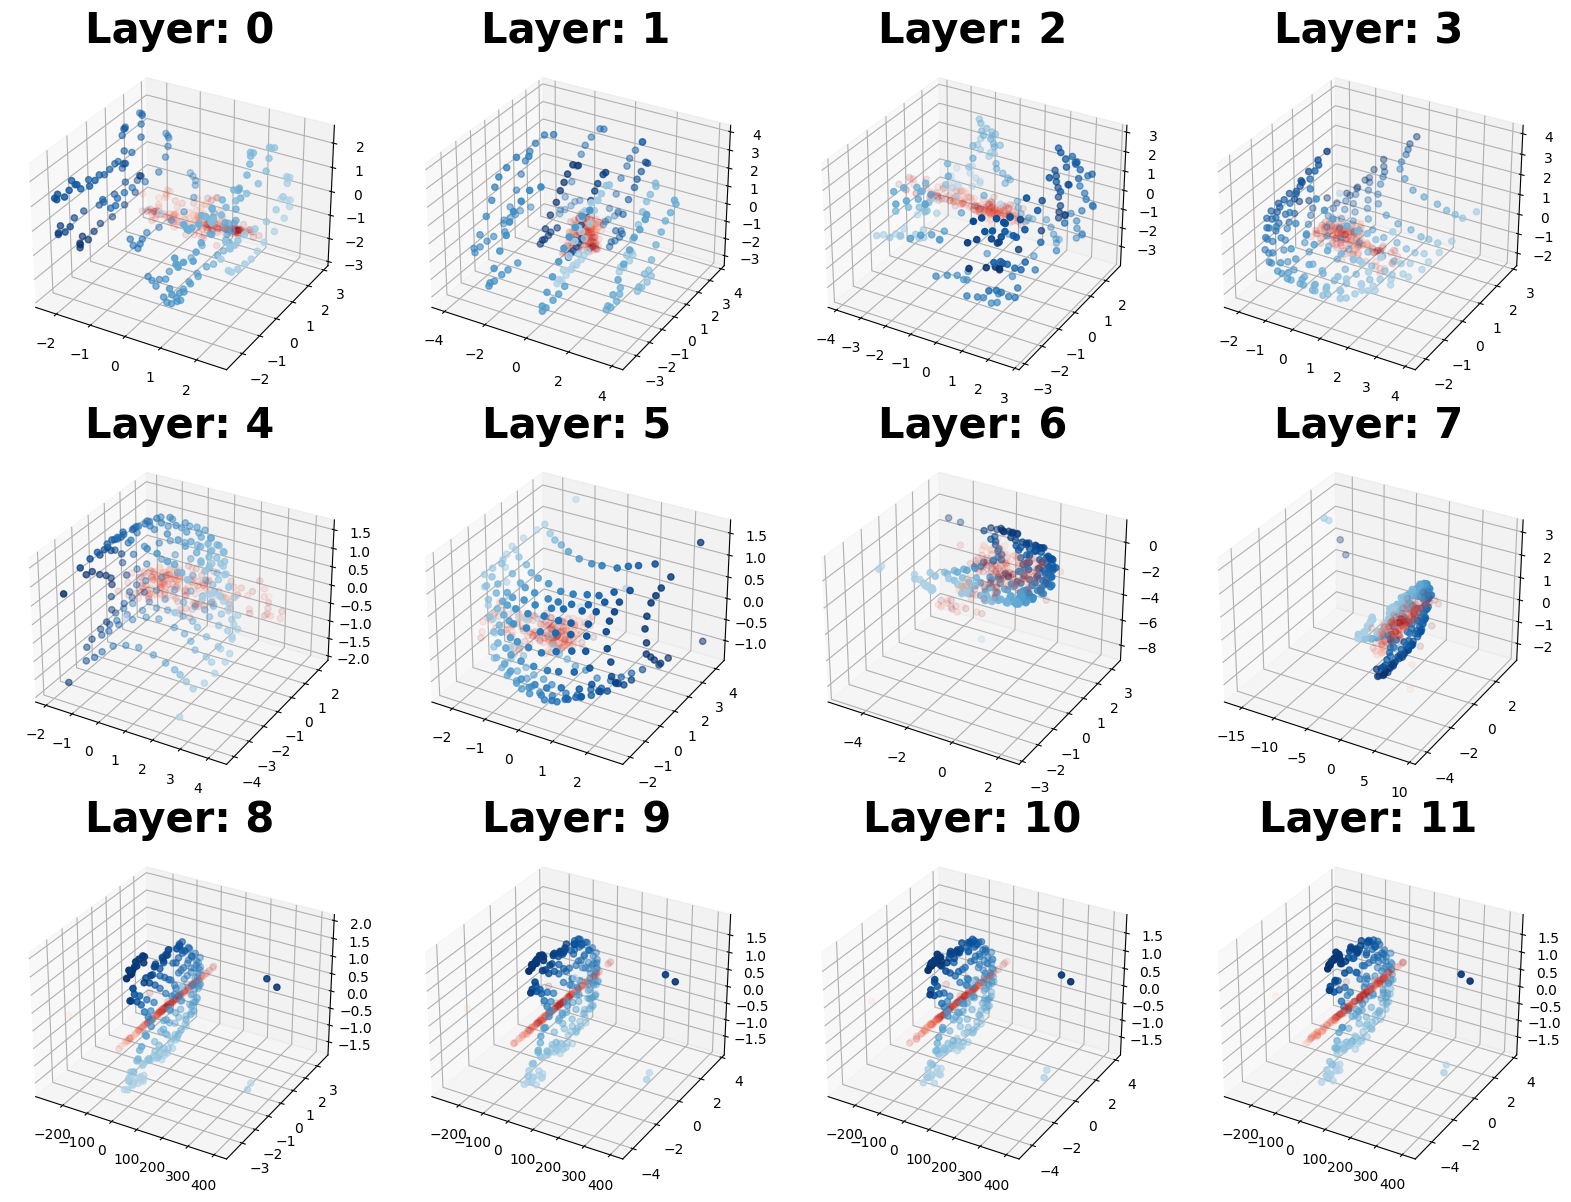

In [33]:
visz_pca_pos_cvec.plot3(res['pos'].detach(),res['cvec'].detach().view(13,-1,192), plot_context=True, remove_axis=False)

## find outliers

In [34]:
pos = res['pos'].detach()
layer_idx = 7
p = pos[layer_idx]
print("p shape: ", p.shape) # [197, 192]

# apply PCA
u, s, vt = np.linalg.svd(p)
proj_mat = vt[:3, :].T

print("proj_mat shape: ", proj_mat.shape) # [192, 3]
pc = p @ proj_mat

pc = pc.detach().numpy()
print("pc shape: ", pc.shape)

p shape:  torch.Size([197, 192])
proj_mat shape:  (192, 3)
pc shape:  (197, 3)


In [35]:
# Assuming `pc` is the projected positional embeddings with shape [T, 3] where T is the sequence length
mean = np.mean(pc, axis=0)
std_dev = np.std(pc, axis=0)

# Define an outlier as any point more than 'n' standard deviations from the mean
n = 7 # This is an arbitrary choice and could be adjusted
outliers = np.where(np.abs(pc - mean) > n * std_dev)[0]

# `outliers` now contains the indices of the outliers in the PC space
outliers

array([196])

In [36]:
pc[outliers]

array([[-15.916639 ,   3.3917112,   0.8404964]], dtype=float32)

## consistent outliers

In [39]:
seed_numSet = [
    (36, "Cifar10"),
    (42, "4sets"), 
    (123, "4sets"),
    (568, "4sets"),
    (568, "3sets"),
]

In [40]:
from utils import intermdiates_to_pos_ctx
for seed, numSet in seed_numSet:
    print(f"======== seed {seed} | numSet {numSet} ========")
    
    ## load res
    loaded_tensor = torch.load(f'{root}/output/{seed}_{numSet}_intermediate_outputs.pth')
    res = intermdiates_to_pos_ctx(loaded_tensor, normalize = False, verbose=False)


    
    pos = res['pos'].detach()

    for layer_idx in range(7,12):
        
        p = pos[layer_idx]

        # apply PCA
        u, s, vt = np.linalg.svd(p)
        proj_mat = vt[:3, :].T

        pc = p @ proj_mat

        pc = pc.detach().numpy()
        # Assuming `pc` is the projected positional embeddings with shape [T, 3] where T is the sequence length
        # Calculate the Euclidean distance from the mean for each point
        mean = np.mean(pc, axis=0)
        distances = np.sqrt(np.sum((pc - mean) ** 2, axis=1))

        # Sort the distances and get the indices of the two largest
        sorted_indices = np.argsort(distances)  # Sorts in ascending order
        two_extreme_outliers = sorted_indices[-2:]  # Take the last two indices for the most extreme values


        print(f"layer {layer_idx}: {two_extreme_outliers}")


======== seed 36 | numSet Cifar10 ========
layer 7: [183 196]
layer 8: [183 196]
layer 9: [183 196]
layer 10: [183 196]
layer 11: [183 196]
======== seed 42 | numSet 4sets ========
layer 7: [183 196]
layer 8: [183 196]
layer 9: [183 196]
layer 10: [183 196]
layer 11: [183 196]
======== seed 123 | numSet 4sets ========
layer 7: [183 196]
layer 8: [183 196]
layer 9: [183 196]
layer 10: [183 196]
layer 11: [183 196]
======== seed 568 | numSet 4sets ========
layer 7: [183 196]
layer 8: [196 183]
layer 9: [196 183]
layer 10: [196 183]
layer 11: [196 183]
======== seed 568 | numSet 3sets ========
layer 7: [183 196]
layer 8: [196 183]
layer 9: [196 183]
layer 10: [196 183]
layer 11: [196 183]


In [23]:
loaded_tensor = torch.load(f'{root}/output/42_4sets_intermediate_outputs.pth')

loaded_tensor[0][[183,196]]

tensor([[[ 0.0556, -0.0154,  0.1520,  ...,  0.0201, -0.0148,  0.0143],
         [ 0.3013,  0.3412, -0.4048,  ..., -0.2768,  0.1841,  0.2332],
         [ 0.5064,  0.7619,  0.1915,  ..., -0.0979,  0.2216,  0.1915],
         ...,
         [-0.0659, -1.2006, -1.2335,  ..., -0.1688,  0.2925, -0.1186],
         [-0.3207, -0.6862,  0.2760,  ...,  0.0946,  0.4087,  0.0433],
         [-0.2517,  0.8450, -0.9396,  ...,  0.0213,  0.4882, -0.7953]],

        [[ 0.0556, -0.0154,  0.1520,  ...,  0.0201, -0.0148,  0.0143],
         [ 0.2816, -2.0473,  2.7975,  ...,  0.7366, -0.1667,  0.2279],
         [-0.0421, -0.9519,  1.4473,  ...,  0.7802,  1.7803,  0.8738],
         ...,
         [ 0.3619,  1.9179, -2.3105,  ...,  0.5159,  0.7553,  0.1278],
         [-0.4892,  0.8254,  0.1454,  ..., -1.2813, -1.8235,  0.6361],
         [-0.3336,  0.4140,  0.6861,  ...,  0.1960,  1.5163, -0.1615]]],
       grad_fn=<IndexBackward0>)